In [59]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\mdurh\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
#source: https://www.kaggle.com/code/ysthehurricane/bitcoin-dogecoin-etc-price-prediction-xgboost/comments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import plotly.express as px
import ta

import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

In [2]:
close=pd.read_csv('data/close.csv')
adj_close=pd.read_csv('data/adj_close.csv')
open=pd.read_csv('data/open.csv')
high=pd.read_csv('data/open.csv')
low=pd.read_csv('data/low.csv')
volume=pd.read_csv('data/volume.csv')

In [3]:
from functools import reduce
dataframes = [close, adj_close, open, high, low, volume]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)

In [4]:
def currency(curr): 
    df=df_merged[['Date',curr+'_x', curr+'_y']]
    df.columns = ['Date','Close', 'Adj_Close','Open','High', 'Low', 'Volume']
    df = ta.utils.dropna(df)
    return df

In [8]:
ada=currency('ADA-USD')
atom=currency('ATOM-USD')
avax=currency('AVAX-USD')
axs=currency('AXS-USD')
btc=currency('BTC-USD')
eth=currency('ETH-USD')
link=currency('LINK-USD')
luna1=currency('LUNA1-USD')
matic=currency('MATIC-USD')
sol=currency('SOL-USD')

#Dictionary with crypto names and datasets
crypto_names = {'ADA-USD':ada, 
               'ATOM-USD':atom,
               'AVAX-USD':avax,
               'AXS-USD':axs,
               'BTC-USD':btc,
               'ETH-USD':eth,
               'LINK-USD':link,
               'LUNA1-USD':luna1,
               'MATIC-USD':matic,
               'SOL-USD':sol}

In [9]:
btc

,Date,Close,Adj_Close,Open,High,Low,Volume
0,2017-04-26,1281.079956,1265.989990,1265.930054,1281.079956,1265.989990,329631008
1,2017-04-27,1317.729980,1281.880005,1281.300049,1317.729980,1281.880005,449196992
2,2017-04-28,1316.479980,1317.739990,1292.369995,1316.479980,1317.739990,527488992
3,2017-04-29,1321.790039,1317.839966,1315.209961,1321.790039,1317.839966,422705984
4,2017-04-30,1347.890015,1321.869995,1314.920044,1347.890015,1321.869995,413115008
...,...,...,...,...,...,...,...
1821,2022-04-21,40527.363281,41371.515625,40063.828125,40527.363281,41371.515625,35372786395
1822,2022-04-22,39740.320312,40525.863281,39315.417969,39740.320312,40525.863281,28011716745
1823,2022-04-23,39486.730469,39738.722656,39352.203125,39486.730469,39738.722656,16138021249
1824,2022-04-24,39469.292969,39478.375000,39233.539062,39469.292969,39478.375000,17964398167


In [284]:
#baseline for a currency
curr = btc[btc['Date'] > '2021-01-01']
curr = curr['Close']
curr_scale = pd.DataFrame(MinMaxScaler().fit_transform(np.array(curr).reshape(-1,1)))

#scaled data
baseline_ytest_scale = curr_scale[1:]
baseline_predictions_scale = curr_scale[:-1]
print("Scaled Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(baseline_ytest_scale, baseline_predictions_scale))))

#unscaled data
baseline_ytest = curr[1:]
baseline_predictions = curr[:-1]

print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(baseline_ytest, baseline_predictions))))

Scaled Root Mean squared Error - RMSE : 0.047279502040918533
Root Mean squared Error - RMSE : 1785.2494338862894


In [10]:
# Add all ta features filling nans values
df = ta.add_all_ta_features(btc, "Open", "High", "Low", "Close", "Volume", fillna=True)

C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
df

,Date,Close,Adj_Close,Open,High,Low,Volume,volume_adi,volume_obv,volume_cmf,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2017-04-26,1281.079956,1265.989990,1265.930054,1281.079956,1265.989990,329631008,3.296310e+08,329631008,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1281.079956,-92.901069,0.000000,0.000000
1,2017-04-27,1317.729980,1281.880005,1281.300049,1317.729980,1281.880005,449196992,7.788280e+08,778828000,1.0,...,0.227735,0.045547,0.182188,2.817835,0.563567,2.254268,1296.763294,2.860869,2.820711,2.860869
2,2017-04-28,1316.479980,1317.739990,1292.369995,1316.479980,1317.739990,527488992,1.306317e+09,251339008,1.0,...,0.395052,0.115448,0.279604,6.566939,1.764241,4.802697,1305.645592,-0.094860,-0.094905,2.763295
3,2017-04-29,1321.790039,1317.839966,1315.209961,1321.790039,1317.839966,422705984,1.729023e+09,674044992,1.0,...,0.553774,0.203113,0.350661,7.041848,2.819763,4.222085,1313.141853,0.403353,0.402541,3.177794
4,2017-04-30,1347.890015,1321.869995,1314.920044,1347.890015,1321.869995,413115008,2.142138e+09,1087160000,1.0,...,0.831173,0.328725,0.502448,7.112954,3.678401,3.434553,1329.144879,1.974593,1.955351,5.215136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-04-21,40527.363281,41371.515625,40063.828125,40527.363281,41371.515625,35372786395,4.146460e+13,1855541134026,1.0,...,-1.708643,-1.370410,-0.338233,0.567928,-2.043221,2.611149,41548.456520,-2.047198,-2.068444,3063.531136
1822,2022-04-22,39740.320312,40525.863281,39315.417969,39740.320312,40525.863281,28011716745,4.149262e+13,1827529417281,1.0,...,-1.867734,-1.469875,-0.397859,0.712566,-1.492064,2.204630,41531.603497,-1.942004,-1.961109,3002.095238
1823,2022-04-23,39486.730469,39738.722656,39352.203125,39486.730469,39738.722656,16138021249,4.150875e+13,1811391396032,1.0,...,-2.022512,-1.580402,-0.442109,-2.736921,-1.741035,-0.995886,41432.227298,-0.638117,-0.640162,2982.300233
1824,2022-04-24,39469.292969,39478.375000,39233.539062,39469.292969,39478.375000,17964398167,4.152672e+13,1793426997865,1.0,...,-2.126183,-1.689558,-0.436625,-4.993543,-2.391537,-2.602006,41405.011444,-0.044160,-0.044170,2980.939077


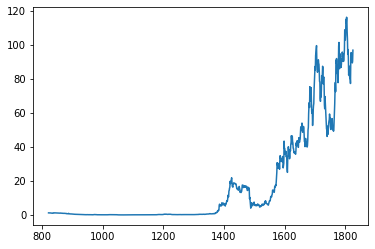

In [12]:
plt.plot(luna1.Close)

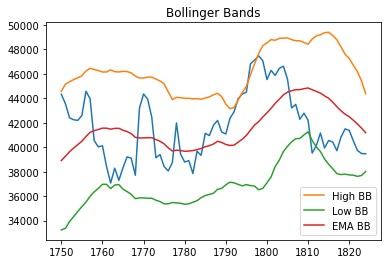

In [53]:
### Bollinger Bands

plt.plot(df[1750:1825].Close)
plt.plot(df[1750:1825].volatility_bbh, label='High BB')
plt.plot(df[1750:1825].volatility_bbl, label='Low BB')
plt.plot(df[1750:1825].volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

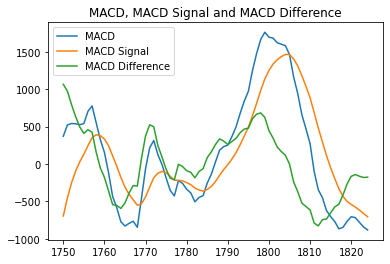

In [55]:
### MACD

plt.plot(df[1750:1825].trend_macd, label='MACD')
plt.plot(df[1750:1825].trend_macd_signal, label='MACD Signal')
plt.plot(df[1750:1825].trend_macd_diff, label='MACD Difference')
plt.title('MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

### Preprocessing

In [13]:
bitcoindf = btc.copy()
bitcoindf = bitcoindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [14]:
bitcoindf['date'] = pd.to_datetime(bitcoindf.date)
bitcoindf.head().style.set_properties(subset=['date','close'], **{'background-color': 'skyblue'})

,date,close,Adj_Close,open,high,low,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2017-04-26 00:00:00,1281.079956,1265.989990,1265.930054,1281.079956,1265.989990,329631008,329631008.000000,329631008,1.000000,0.000000,0.000000,0.000000,-249484793.277680,1276.049967,50.000000,1000.000000,1281.079956,1281.079956,1281.079956,0.000000,0.000000,0.000000,0.000000,1276.049967,1291.139933,1260.960002,2.365106,0.666667,0.000000,0.000000,1265.989990,1281.079956,1273.534973,1.177910,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1281.079956,1281.079956,1281.079956,1281.079956,0.000000,0.000000,0.000000,-92.713349,1.000000,16765.017052,-929.010691,-929.010691,0.000000,1273.534973,1273.534973,1273.534973,1273.534973,0.000000,0.000000,0.000000,0.000000,0.000000,17896.031352,17654.510580,4.000000,4.000000,0.000000,1265.989990,1848.569946,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1281.079956,-92.901069,0.000000,0.000000
1,2017-04-27 00:00:00,1317.729980,1281.880005,1281.300049,1317.729980,1281.880005,449196992,778828000.000000,778828000,1.000000,16463080723.523438,209.658474,209.658474,-293379791.253526,1293.197060,100.000000,1000.000000,1299.404968,1336.054993,1262.754944,5.641047,0.750000,0.000000,0.000000,1290.914978,1316.384949,1265.445007,3.946034,1.026404,1.000000,0.000000,1265.989990,1317.729980,1291.859985,3.981822,1.000000,0.000000,0.000000,2.923649,0.584730,2.338919,1299.404968,1299.404968,1286.718421,1283.794773,0.003077,0.000048,0.003029,0.005588,2.208639,16746.692040,-927.995235,-928.502963,0.507728,1291.859985,1291.859985,1291.859985,1291.859985,0.000000,0.000000,0.000000,0.000000,66.666667,17896.031352,17654.510580,8.000000,4.000000,4.000000,1265.989990,1848.569946,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,100.000000,70.835005,100.000000,100.000000,-0.000000,0.000000,0.000000,0.227735,0.045547,0.182188,2.817835,0.563567,2.254268,1296.763294,2.860869,2.820711,2.860869
2,2017-04-28 00:00:00,1316.479980,1317.739990,1292.369995,1316.479980,1317.739990,527488992,1306316992.000000,251339008,1.000000,14017017585.877234,-4.133633,102.762420,12350562.682014,1302.768268,100.000000,1000.000000,1305.096639,1339.076689,1271.116589,5.207285,0.667500,0.000000,0.000000,1299.576647,1316.136624,1283.016669,2.548519,1.010367,1.000000,0.000000,1265.989990,1317.729980,1291.859985,3.964457,0.975841,0.000000,0.000000,5.081224,1.484029,3.597195,1305.096639,1305.096639,1291.297123,1286.215899,0.005134,0.000048,0.005086,0.014476,3.169117,16741.000369,-927.679839,-928.228588,0.548749,1291.859985,1291.859985,1291.859985,1291.859985,0.000000,0.000000,0.000000,0

Text(0.5, 1.0, 'Bitcoin Close Price')

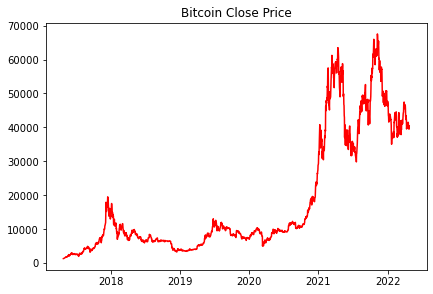

In [15]:
fig = plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(bitcoindf['date'], bitcoindf['close'], color="red")
plt.title('Bitcoin Close Price')

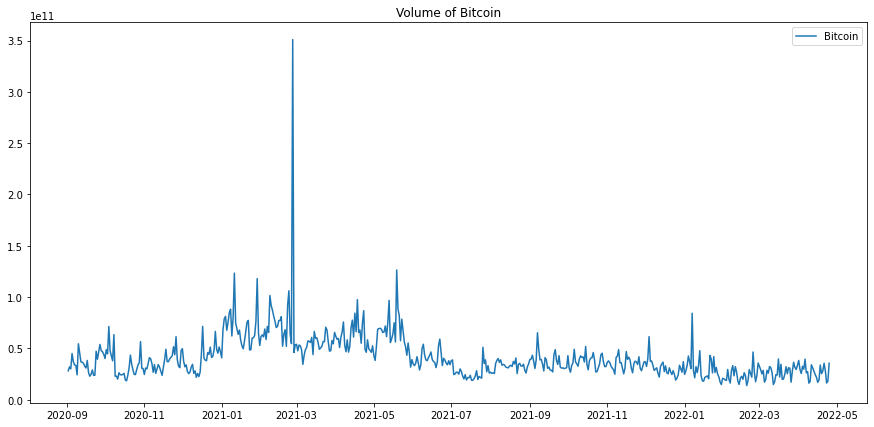

In [15]:
fig = plt.figure(figsize = (15,7))

plt.plot(last1year_bitcoindf['date'] , last1year_bitcoindf['volume'])
plt.title('Volume of Bitcoin')
plt.legend(['Bitcoin'])


plt.show()

#  Bitcoin Close Price Prediction using XGBoost

#### Dataframe of bitcoin close price

In [236]:
closedf = bitcoindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)
#'date','close',"trend_macd", "volume" 

Shape of close dataframe: (1826, 2)


In [237]:
closedf = closedf[closedf['date'] > '2021-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  479


In [238]:
close_stock

,date,close
1347,2021-01-02,32127.267578
1348,2021-01-03,32782.023438
1349,2021-01-04,31971.914062
1350,2021-01-05,33992.429688
1351,2021-01-06,36824.363281
...,...,...
1821,2022-04-21,40527.363281
1822,2022-04-22,39740.320312
1823,2022-04-23,39486.730469
1824,2022-04-24,39469.292969


#### Separate data for Train and Test

In [239]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf.iloc[0:training_size,:],closedf.iloc[training_size:len(closedf),:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (335, 2)
test_data:  (144, 2)


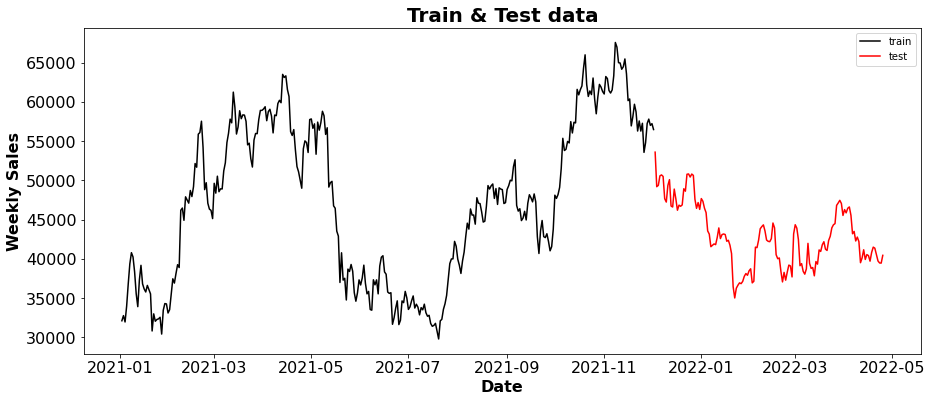

In [240]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:training_size], y = close_stock['close'][:training_size], color = 'black')
sns.lineplot(x = close_stock['date'][training_size:], y = close_stock['close'][training_size:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

#### Normalizing close price value

In [241]:
del train_data['date']
del test_data['date']
scaler = MinMaxScaler()
scaler_y = MinMaxScaler().fit(np.array(train_data['close']).reshape(-1,1)) 
scaler.fit(train_data)
X_train_scaled = pd.DataFrame(scaler.transform(train_data)) 
X_test_scaled = pd.DataFrame(scaler.transform(test_data))

In [242]:
train_data.iloc[:,0]

1347    32127.267578
1348    32782.023438
1349    31971.914062
1350    33992.429688
1351    36824.363281
            ...     
1677    57248.457031
1678    57806.566406
1679    57005.425781
1680    57229.828125
1681    56477.816406
Name: close, Length: 335, dtype: float64

In [232]:
X_test_scaled[-15:]

,0,1,2
129,0.257275,0.479465,0.045644
130,0.273305,0.455913,0.036738
131,0.300835,0.445871,0.026802
132,0.268228,0.428989,0.016720
133,0.284594,0.421222,0.008938
134,0.281178,0.414917,-0.005885
135,0.262440,0.405360,0.000902
136,0.291817,0.407398,0.044907
137,0.309734,0.415154,0.019614
138,0.306334,0.421084,0.027189


#### Prepare train data for time series analysis

In [243]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [244]:
time_step = 15
X_train, y_train = create_dataset(X_train_scaled, time_step)
X_test, y_test = create_dataset(X_test_scaled, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (319, 15)
y_train:  (319,)
X_test:  (128, 15)
y_test (128,)


#### Import XGBRegressor module and Fit X_train and y_train for training model

In [245]:
from xgboost import XGBRegressor
my_model2 = XGBRegressor(n_estimators=1000)
my_model2.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

#### Model testing and evaluation

In [246]:
#second run with "close", 
predictions = my_model2.predict(X_test)
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Root Mean squared Error - RMSE : 0.04745400373034746


In [125]:
#second run with "close", "trend_macd", "volume", momentum_rsi
predictions = my_model2.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03600010983476512
Root Mean squared Error - RMSE : 0.04745400373034746


In [94]:
#second run with "close", "trend_macd", "volume"
predictions = my_model1.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03600010983476512
Root Mean squared Error - RMSE : 0.04745400373034746


In [24]:
#first run - just with close data
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03586139649678331
Root Mean squared Error - RMSE : 0.04974812278025246


In [247]:
train_predict=my_model2.predict(X_train)
test_predict=my_model2.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (319, 1)
Test data prediction: (128, 1)


In [248]:
# Transform back to original form

train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
original_ytrain = scaler_y.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler_y.inverse_transform(y_test.reshape(-1,1)) 

In [249]:
#unscaled datasets
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(original_ytest, test_predict))))

Root Mean squared Error - RMSE : 1791.8385794255676


In [250]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf[['close']])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf[['close']])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


Train predicted data:  (479, 1)
Test predicted data:  (479, 1)


In [271]:
#Predicting tomorrow

tomorrow_scaled = my_model2.predict(X_test)[-1]
tomorrow = scaler_y.inverse_transform(tomorrow_scaled.reshape(-1,1)) 
tomorrow

array([[40506.117]], dtype=float32)

In [281]:
appended_X_test_scaled = X_test_scaled.append([float(tomorrow_scaled)], ignore_index = True)

In [282]:
#Predicting day after tomorrow
X_test_append, y_test_append = create_dataset(appended_X_test_scaled, time_step)

In [283]:
tomorrow_tomorrow_scaled = my_model2.predict(X_test_append)[-1]
tomorrow_tomorrow = scaler_y.inverse_transform(tomorrow_tomorrow_scaled.reshape(-1,1)) 
tomorrow_tomorrow

array([[40334.168]], dtype=float32)